# Introduction to Deep Learning - Week 3

## CNN Cancer Detection Kaggle Mini Project



**Github link**



Cancer detection is an application of machine learning that can provide great benefits. Previously, highly trained doctors and medical professionals have had to analyze imaging for cancerous growth; thus, having a way to accurately automate this process would provide efficiencies in diagnosis and treatment. In this project I will build a convolutional neural network (CNN) model to detect cancerous cells and classify the histology images as positive or negative.

### Import Libraries



The following libraries will be used in my project.

In [2]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore", FutureWarning)



import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

from PIL import Image
from glob import glob

import cv2
import gc
import os

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix



import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 

### Load the Data



The data comes from the "Histopathologic Cancer Detection" Kaggle competition. It consists of two folders of training and test image files, plus a .csv file for the training data that maps the image file names to a label feature with value of '0' for no cancer present or '1' for cancerous growth present. The training file contains 220025 images in the .tif format.  The test folder contains 57458 .tif images to test the model for the Kaggle competition.



**Data Citation**



Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

In [3]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(df.shape)
df.head(5)

(220025, 2)


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

### Exploratory Data Analysis



Out of 220025 training images, 130908 were negative and 89117 were positive. The image sizes were 96x96. In this section I create a visualization showing the distribution of positive versus negative images. I also display some examples of images that detected cancerous growth and images of normal growth (see images below). At first glance, the images look very similar to each other, however, discrepancies such as size and shape can be seen. The images that have cancerous growth appear to have cells that are more abnormally shaped or elongated while the non-cancerous cells are smaller and more round. It will be interesting to see how well the model detects these differences.  



In order to make the data easier to work with, I take a smaller random sample of the data files. I also make this an equal 50/50 sampling of positive and negative images.  

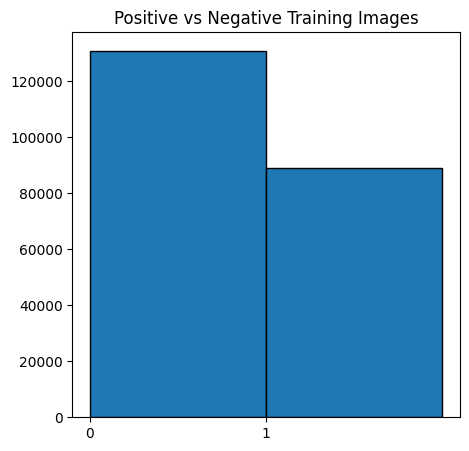

Number of records: 220025
Number of Neg: 130908
Number of Pos: 89117


In [4]:
plt.figure(figsize = (5,5))
plt.hist(df["label"],bins=range(3), ec='k')
plt.xticks([0,1])
plt.title("Positive vs Negative Training Images")
plt.show()


print("Number of records:", len(df))
print("Number of Neg:", (df["label"]== 0).sum())
print("Number of Pos:", (df["label"]== 1).sum())

In [5]:
#########
# Selecting a random sample of the training data for efficiency purposes 
#########
sample_size = 80000

train_path = '/kaggle/input/histopathologic-cancer-detection/train/'

df_neg = df[df['label'] == 0].sample(sample_size, random_state=1234)
df_pos = df[df['label'] == 1].sample(sample_size, random_state=1234)

train_df = sklearn.utils.shuffle(pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True))
train_df.shape

(160000, 2)

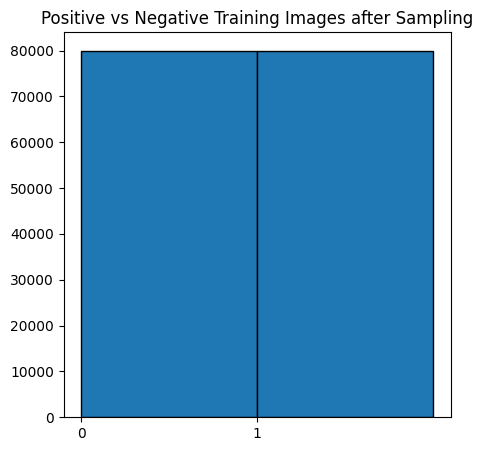

In [6]:
plt.figure(figsize = (5,5))
plt.hist(train_df["label"],bins=range(3), ec='k')
plt.xticks([0,1])
plt.title("Positive vs Negative Training Images after Sampling")
plt.show()


Image size:  27648
Image size:  27648
Image size:  27648
Image size:  27648


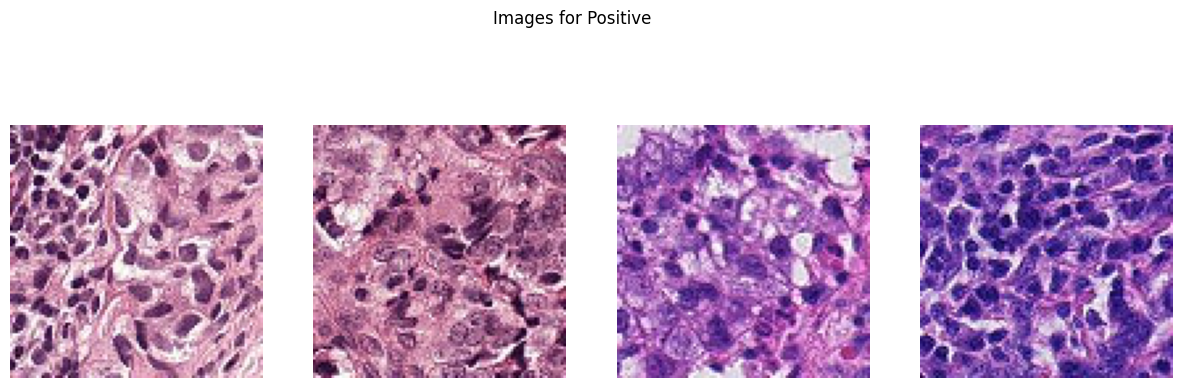

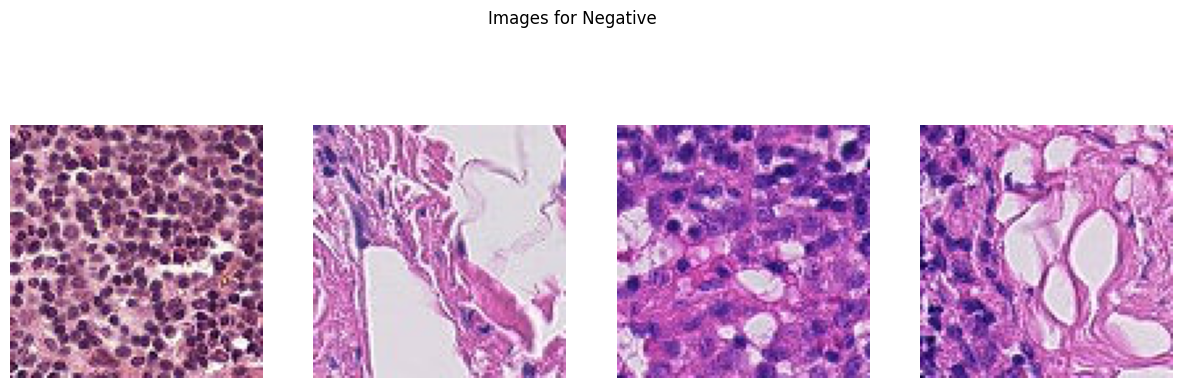

In [7]:
###################
## This code plots sample images for negative and positive labels
###################

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Images for Positive')

pos_list =  df_pos['id'].head(4)  
j = 0

for i in pos_list:
    img = np.array(Image.open(f'{train_path}/{i}.tif'))
    print("Image size: ", img.size)
    ax[j].imshow(img)
    ax[j].axis('off')    
    j=j+1


plt.show()



fig, ax = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Images for Negative')

neg_list =  df_neg['id'].head(4)  
j = 0

for i in neg_list:
    img = np.array(Image.open(f'{train_path}/{i}.tif'))
    ax[j].imshow(img)
    ax[j].axis('off')    
    j=j+1

    
plt.show()

### Cleaning the Data



In this section I clean and prepare the data to be used with the CNN model. Here I convert the image pixels into numpy arrays. I also split the dataset into test and training sets for validation.

In [8]:
#############
# Create datasets for the model as np arrays
#############

x = []
y = []

df_list =  train_df['id']

# target value label classifier
y = train_df['label']

#here I open and store pixel info per image in array
for i in df_list:
    img = cv2.imread(f'{train_path}{i}.tif')
    x.append(img)

    
y = np.array(y)
x = np.array(x)    

#use to predict probablity of being pos or neg
encoded_y = pd.get_dummies(y).values

In [9]:
#############
# Splitting into test and train
##############

X_train, X_test, y_train, y_test = train_test_split(x, encoded_y,
                                                  test_size = 0.2,
                                                  random_state = 1234)
print(X_train.shape, y_train.shape)


(128000, 96, 96, 3) (128000, 2)


### Modeling the Data



I build a convolutional neural network model using Keras from the TensorFlow library. I create a three convolution layers with max pooling. Next I flatten the convolution output and use two fully connected dense layers with rectified linear unit activation functions followed by batch normalization. I use a dropout layer and then a final layer using softmax to convert the lilihood to either '0' or '1'. Below is a print out of the model summary. In total there are over 3 million trainable parameters.

In [10]:
###################
# This builds the CNN model
###################

model = tf.keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(96, 96, 3)),

    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2, activation='softmax')

])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 92, 92, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,406,530 (12.99 MB)

 Trainable params: 3,405,762 (12.99 MB)

 Non-trainable params: 768 (3.00 KB)

### Results and Analysis



In compiling the model I use the ADAM optimizing technique for gradient descent. I use the binary cross entropy loss function and will use AUC and accuracy for model evaluation. I also use callbacks to check whether improvements are made. 



I will test model performance at four different epoch sizes (5, 10, 15, 20) and 2 different batch sizes (36, 64) as hyperparameter tuning. I plot the loss per epoch and the AUC per epoch for both the training and validation data to get an idea of overfitting. I also look at confusion matrices for each model.

I initially used early stopping, but removed this in order to get a better understanding of the models for comparison.


In [11]:
#############
# This code sets hyperparameters for tweaking
#############
EPOCHS = 5
BATCH_SIZE = 36
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['AUC']

#creating a list for accurary comparison
acc_list_36 = []
acc_list_64 = []


In [12]:
# Compile and train the model

#es = EarlyStopping(patience=3,
#                   monitor='val_loss',
#                   restore_best_weights=True)



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS) 


Epoch 1/5


I0000 00:00:1730725778.205687     480 service.cc:145] XLA service 0x567fe5dfb550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730725778.205730     480 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730725778.205734     480 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  18/3556 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - AUC: 0.6133 - loss: 0.8164

I0000 00:00:1730725783.239038     480 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3556/3556 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step - AUC: 0.8478 - loss: 0.4987 - val_AUC: 0.5538 - val_loss: 2.4596 - learning_rate: 0.0010
Epoch 2/5
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - AUC: 0.8901 - loss: 0.4177 - val_AUC: 0.7854 - val_loss: 0.6061 - learning_rate: 0.0010
Epoch 3/5
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9043 - loss: 0.3909 - val_AUC: 0.7304 - val_loss: 0.9388 - learning_rate: 0.0010
Epoch 4/5
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9141 - loss: 0.3701 - val_AUC: 0.8312 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 5/5
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9245 - loss: 0.3468 - val_AUC: 0.6280 - val_loss: 2.7273 - learning_rate: 0.0010


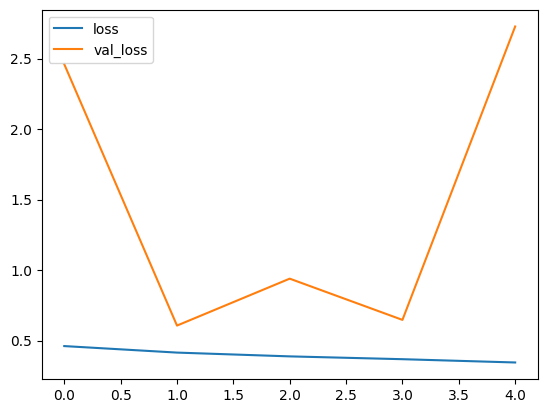

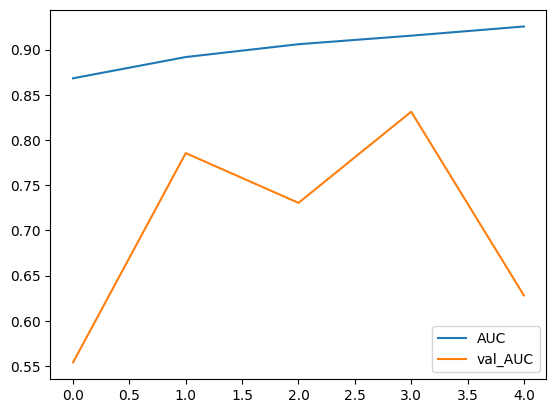

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model Test (EPOCH 5, BATCH 36)  Accuracy:  0.599875


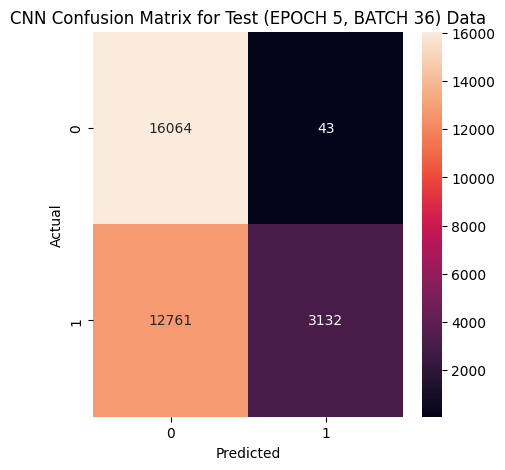

In [13]:
cnn_model = model.fit(X_train, y_train, 
                        validation_data = (X_test, y_test), 
                        batch_size = BATCH_SIZE,
                        epochs=EPOCHS, 
                        callbacks=[reduce_lr]) 
#plot loss vs epoch and auc vs epoch
history_1 = pd.DataFrame(cnn_model.history)
history_1.loc[:,['loss','val_loss']].plot()
history_1.loc[:,['AUC','val_AUC']].plot()
plt.show()
#determine accuracy
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_test, axis=1)
acc = accuracy_score(y_val, y_pred)
acc_list_36.append(acc)

print("Model Test (EPOCH 5, BATCH 36)  Accuracy: ", acc)
# plot confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))

plt.title("CNN Confusion Matrix for Test (EPOCH 5, BATCH 36) Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Epoch 1/10
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - AUC: 0.9302 - loss: 0.3327 - val_AUC: 0.8089 - val_loss: 0.7164 - learning_rate: 0.0010
Epoch 2/10
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9372 - loss: 0.3154 - val_AUC: 0.7507 - val_loss: 1.0254 - learning_rate: 0.0010
Epoch 3/10
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9420 - loss: 0.3018 - val_AUC: 0.9293 - val_loss: 0.3364 - learning_rate: 0.0010
Epoch 4/10
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9470 - loss: 0.2882 - val_AUC: 0.9477 - val_loss: 0.2879 - learning_rate: 0.0010
Epoch 5/10
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9478 - loss: 0.2856 - val_AUC: 0.8763 - val_loss: 0.5155 - learning_rate: 0.0010
Epoch 6/10
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9420 - loss: 0.3012 - val_AUC: 0.9329 - val_loss: 0.3309 - learning_rate: 0.0010
Epoch 7/10
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9540 - loss: 0.2658 - val_AUC: 0.9354 - val_loss: 0.3368 - 

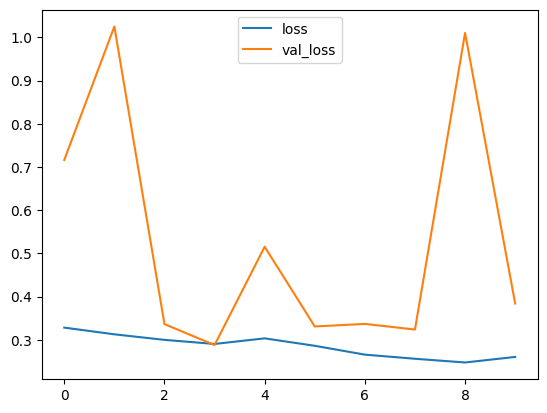

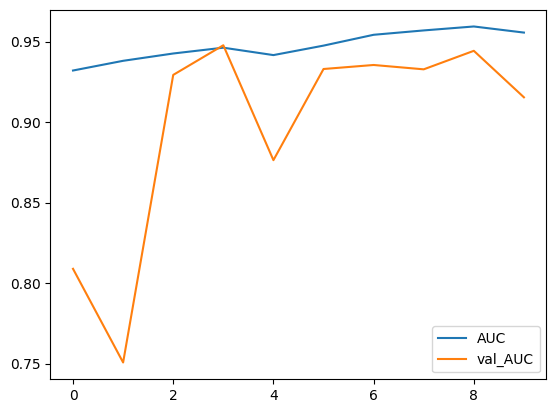

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model Test (EPOCH 10, BATCH 36)  Accuracy:  0.846125


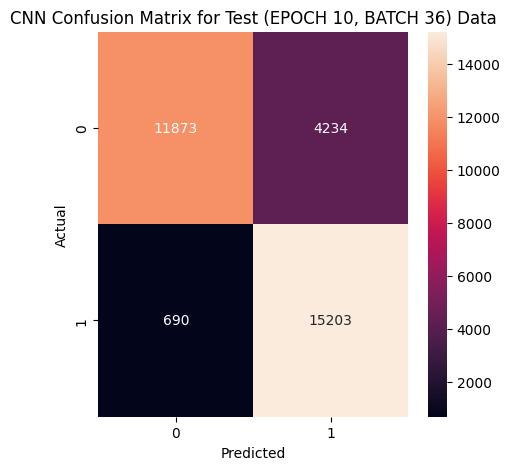

In [14]:
#################
# New Model with increased epochs (EPOCHS = 10)
##################

EPOCHS = 10
BATCH_SIZE = 36

cnn_model = model.fit(X_train, y_train, 
                        validation_data = (X_test, y_test), 
                        batch_size = BATCH_SIZE,
                        epochs=EPOCHS, 
                        callbacks=[reduce_lr]) 

#plot loss vs epoch and auc vs epoch

history_2 = pd.DataFrame(cnn_model.history)
history_2.loc[:,['loss','val_loss']].plot()
history_2.loc[:,['AUC','val_AUC']].plot()

plt.show()
#determine accuracy
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_test, axis=1)

acc = accuracy_score(y_val, y_pred)

acc_list_36.append(acc)

print("Model Test (EPOCH 10, BATCH 36)  Accuracy: ", acc)

# plot confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(conf_mat, annot=True, fmt='d',

            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))

plt.title("CNN Confusion Matrix for Test (EPOCH 10, BATCH 36) Data")

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()


Epoch 1/15
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - AUC: 0.9640 - loss: 0.2321 - val_AUC: 0.9365 - val_loss: 0.3211 - learning_rate: 0.0010
Epoch 2/15
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9658 - loss: 0.2244 - val_AUC: 0.8317 - val_loss: 0.6512 - learning_rate: 0.0010
Epoch 3/15
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9684 - loss: 0.2154 - val_AUC: 0.8661 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 4/15
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9694 - loss: 0.2108 - val_AUC: 0.7501 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 5/15
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9719 - loss: 0.2017 - val_AUC: 0.9115 - val_loss: 0.3971 - learning_rate: 0.0010
Epoch 6/15
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9711 - loss: 0.2038 - val_AUC: 0.9442 - val_loss: 0.2993 - learning_rate: 0.0010
Epoch 7/15
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9711 - loss: 0.2045 - val_AUC: 0.9415 - val_loss: 0.9265 - 

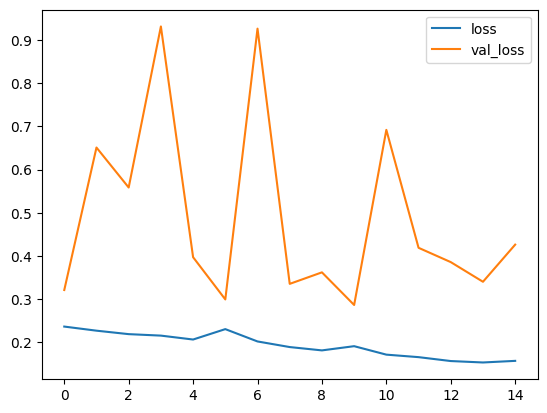

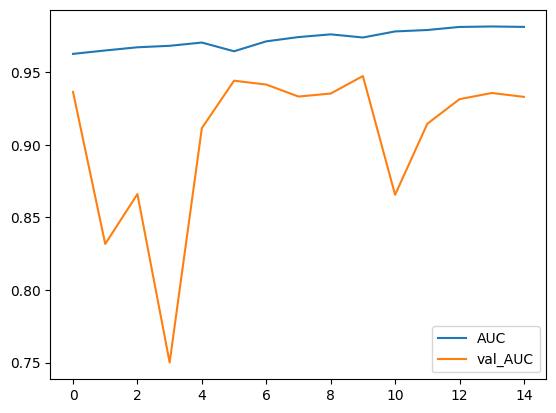

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model Test (EPOCH 15, BATCH 36)  Accuracy:  0.88184375


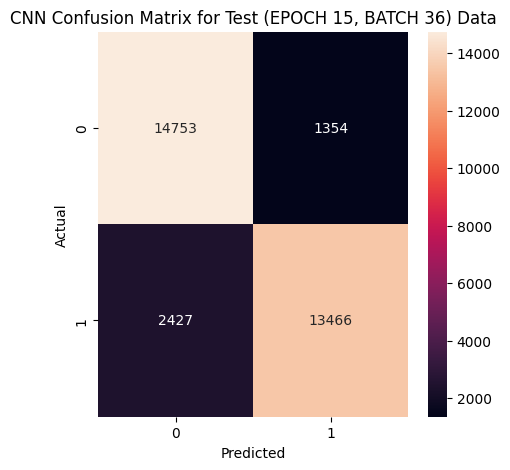

In [15]:
#################
# New Model with increased epochs (EPOCHS = 15)
##################

EPOCHS = 15
BATCH_SIZE = 36


cnn_model = model.fit(X_train, y_train, 
                        validation_data = (X_test, y_test), 
                        batch_size = BATCH_SIZE,
                        epochs=EPOCHS, 
                        callbacks=[reduce_lr]) 


#plot loss vs epoch and auc vs epoch
history_3 = pd.DataFrame(cnn_model.history)
history_3.loc[:,['loss','val_loss']].plot()
history_3.loc[:,['AUC','val_AUC']].plot()

plt.show()

#determine accuracy
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_test, axis=1)

acc = accuracy_score(y_val, y_pred)
acc_list_36.append(acc)


print("Model Test (EPOCH 15, BATCH 36)  Accuracy: ", acc)
# plot confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))

plt.title("CNN Confusion Matrix for Test (EPOCH 15, BATCH 36) Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Epoch 1/20
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - AUC: 0.9840 - loss: 0.1418 - val_AUC: 0.9340 - val_loss: 0.3899 - learning_rate: 0.0010
Epoch 2/20
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9848 - loss: 0.1359 - val_AUC: 0.9144 - val_loss: 0.4641 - learning_rate: 0.0010
Epoch 3/20
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9861 - loss: 0.1279 - val_AUC: 0.9264 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 4/20
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9864 - loss: 0.1263 - val_AUC: 0.9106 - val_loss: 0.4563 - learning_rate: 0.0010
Epoch 5/20
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9879 - loss: 0.1185 - val_AUC: 0.9219 - val_loss: 0.4450 - learning_rate: 0.0010
Epoch 6/20
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9884 - loss: 0.1123 - val_AUC: 0.9241 - val_loss: 0.4022 - learning_rate: 0.0010
Epoch 7/20
3556/3556 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - AUC: 0.9893 - loss: 0.1080 - val_AUC: 0.9139 - val_loss: 0.4272 - 

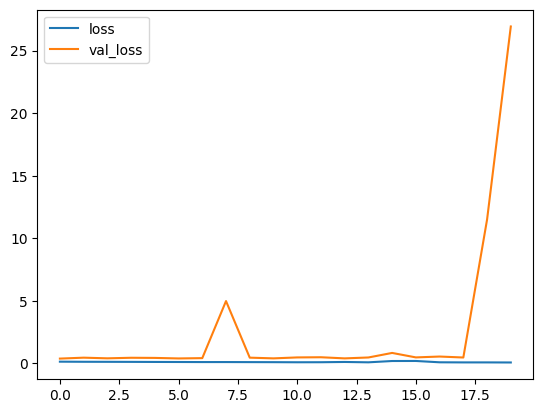

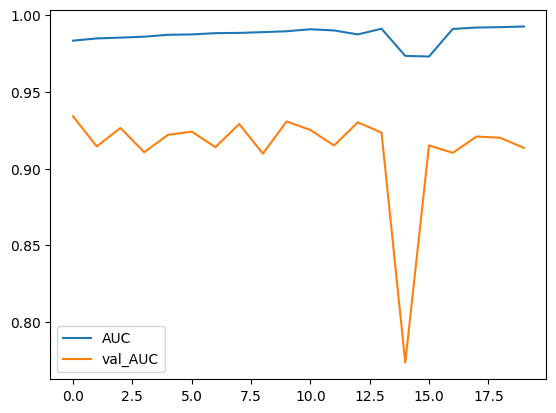

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model Test (EPOCH 20, BATCH 36)  Accuracy:  0.87325


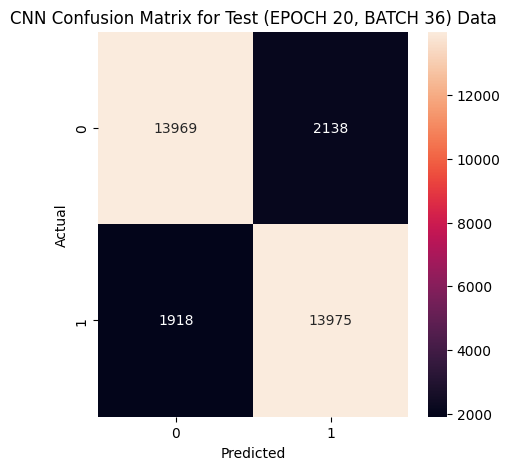

In [16]:
#################
# New Model with increased epochs (EPOCHS = 20)
##################

EPOCHS = 20
BATCH_SIZE = 36


cnn_model = model.fit(X_train, y_train, 
                        validation_data = (X_test, y_test), 
                        batch_size = BATCH_SIZE,
                        epochs=EPOCHS, 
                        callbacks=[reduce_lr]) 


#plot loss vs epoch and auc vs epoch
history_4 = pd.DataFrame(cnn_model.history)
history_4.loc[:,['loss','val_loss']].plot()
history_4.loc[:,['AUC','val_AUC']].plot()
plt.show()


#determine accuracy
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_test, axis=1)


acc = accuracy_score(y_val, y_pred)
acc_list_36.append(acc)

print("Model Test (EPOCH 20, BATCH 36)  Accuracy: ", acc)


#plot confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))

plt.title("CNN Confusion Matrix for Test (EPOCH 20, BATCH 36) Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Epoch 1/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - AUC: 0.9973 - loss: 0.0425 - val_AUC: 0.9026 - val_loss: 1.1667 - learning_rate: 0.0010
Epoch 2/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9968 - loss: 0.0441 - val_AUC: 0.9143 - val_loss: 0.6017 - learning_rate: 0.0010
Epoch 3/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9968 - loss: 0.0411 - val_AUC: 0.9181 - val_loss: 0.6005 - learning_rate: 0.0010
Epoch 4/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9970 - loss: 0.0398 - val_AUC: 0.9107 - val_loss: 0.6436 - learning_rate: 0.0010
Epoch 5/5
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9968 - loss: 0.0386 - val_AUC: 0.9078 - val_loss: 0.7300 - learning_rate: 0.0010


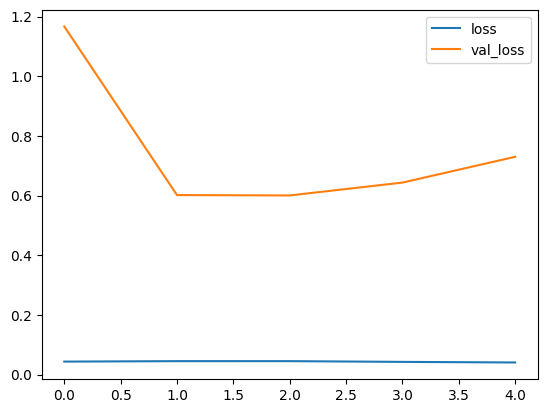

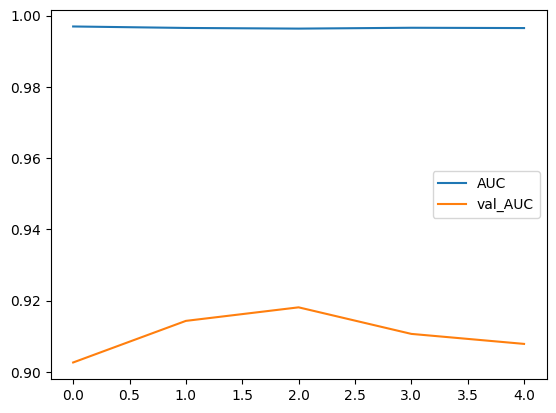

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model Test (EPOCH 5, BATCH 64)  Accuracy:  0.8776875


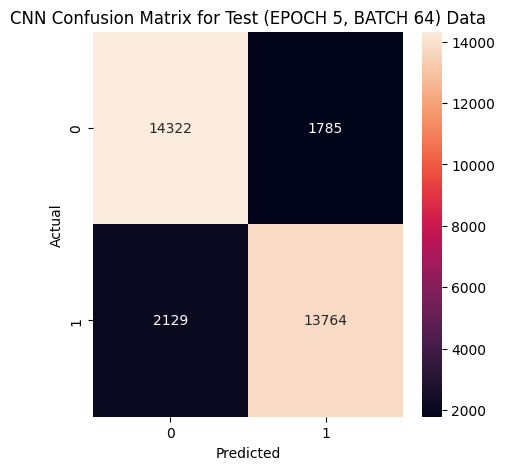

In [17]:
#################
# New Model with increased batch size (BATCH_SIZE = 64 EPOCHS = 5)
##################

EPOCHS = 5
BATCH_SIZE = 64


cnn_model = model.fit(X_train, y_train, 
                        validation_data = (X_test, y_test), 
                        batch_size = BATCH_SIZE,
                        epochs=EPOCHS, 
                        callbacks=[reduce_lr]) 


#plot loss vs epoch and auc vs epoch
history_5 = pd.DataFrame(cnn_model.history)
history_5.loc[:,['loss','val_loss']].plot()
history_5.loc[:,['AUC','val_AUC']].plot()
plt.show()

#determine accuracy
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_test, axis=1)

acc = accuracy_score(y_val, y_pred)
acc_list_64.append(acc)



print("Model Test (EPOCH 5, BATCH 64)  Accuracy: ", acc)

# plot confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))

plt.title("CNN Confusion Matrix for Test (EPOCH 5, BATCH 64) Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - AUC: 0.9967 - loss: 0.0415 - val_AUC: 0.9096 - val_loss: 0.6683 - learning_rate: 0.0010
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9972 - loss: 0.0360 - val_AUC: 0.9131 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9976 - loss: 0.0320 - val_AUC: 0.8993 - val_loss: 0.7559 - learning_rate: 0.0010
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9971 - loss: 0.0358 - val_AUC: 0.9090 - val_loss: 0.7143 - learning_rate: 0.0010
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9973 - loss: 0.0332 - val_AUC: 0.9120 - val_loss: 0.7015 - learning_rate: 0.0010
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9974 - loss: 0.0319 - val_AUC: 0.9124 - val_loss: 0.7055 - learning_rate: 0.0010
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9979 - loss: 0.0300 - val_AUC: 0.9000 - val_loss: 0.9138 - 

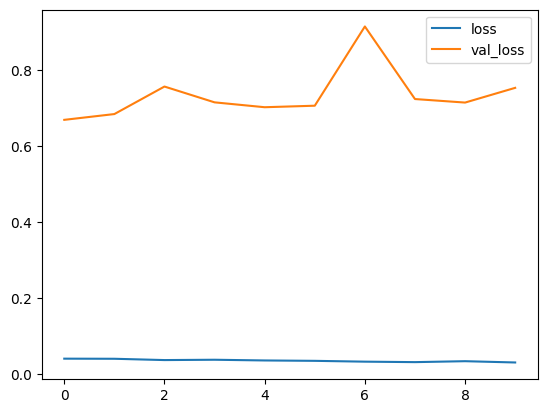

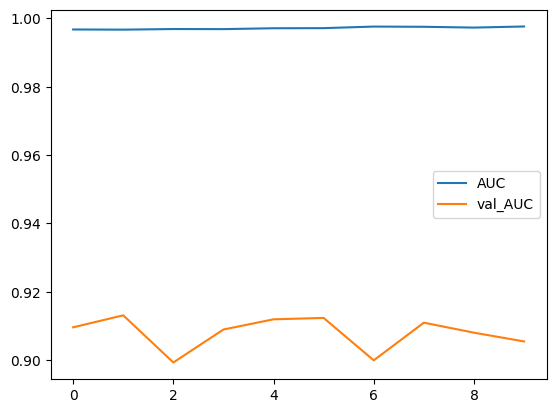

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model Test (EPOCH 10, BATCH 64)  Accuracy:  0.87325


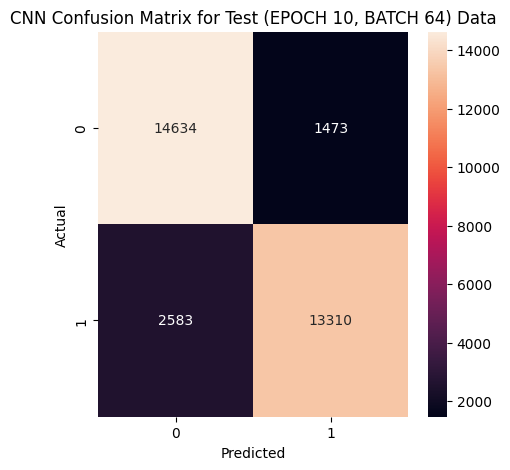

In [18]:
#################
# New Model with increased batch size (BATCH_SIZE = 64 EPOCHS = 10)
##################

EPOCHS = 10
BATCH_SIZE = 64


cnn_model = model.fit(X_train, y_train, 
                        validation_data = (X_test, y_test), 
                        batch_size = BATCH_SIZE,
                        epochs=EPOCHS, 
                        callbacks=[reduce_lr]) 


#plot loss vs epoch and auc vs epoch
history_6 = pd.DataFrame(cnn_model.history)
history_6.loc[:,['loss','val_loss']].plot()
history_6.loc[:,['AUC','val_AUC']].plot()
plt.show()

#determine accuracy
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_test, axis=1)

acc = accuracy_score(y_val, y_pred)
acc_list_64.append(acc)



print("Model Test (EPOCH 10, BATCH 64)  Accuracy: ", acc)


#confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))

plt.title("CNN Confusion Matrix for Test (EPOCH 10, BATCH 64) Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - AUC: 0.9978 - loss: 0.0281 - val_AUC: 0.9021 - val_loss: 0.7849 - learning_rate: 0.0010
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9977 - loss: 0.0290 - val_AUC: 0.8849 - val_loss: 0.9930 - learning_rate: 0.0010
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9978 - loss: 0.0276 - val_AUC: 0.8913 - val_loss: 0.8941 - learning_rate: 0.0010
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9972 - loss: 0.0293 - val_AUC: 0.9070 - val_loss: 0.7618 - learning_rate: 0.0010
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9982 - loss: 0.0236 - val_AUC: 0.8411 - val_loss: 1.4234 - learning_rate: 0.0010
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9965 - loss: 0.0364 - val_AUC: 0.9015 - val_loss: 0.7691 - learning_rate: 0.0010
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9983 - loss: 0.0232 - val_AUC: 0.9096 - val_loss: 0.8073 - 

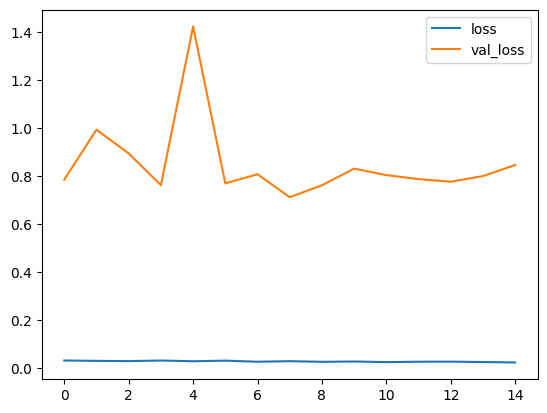

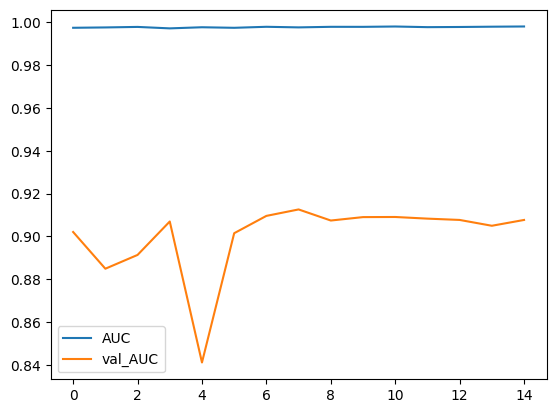

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model Test (EPOCH 15, BATCH 64)  Accuracy:  0.88225


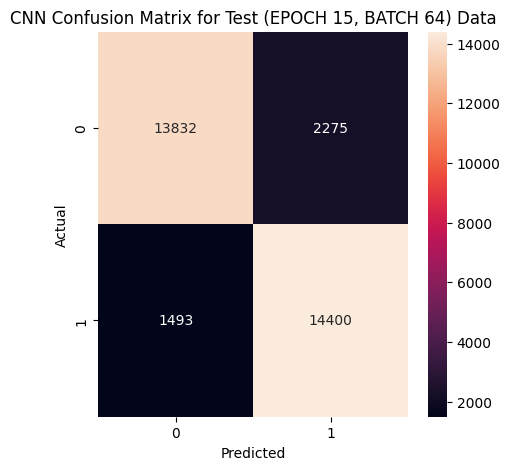

In [19]:
#################
# New Model with increased  batch size (BATCH_SIZE = 64 EPOCHS = 15)
##################

EPOCHS = 15
BATCH_SIZE = 64


cnn_model = model.fit(X_train, y_train, 
                        validation_data = (X_test, y_test), 
                        batch_size = BATCH_SIZE,
                        epochs=EPOCHS, 
                        callbacks=[reduce_lr]) 


#plot loss vs epoch and auc vs epoch
history_7 = pd.DataFrame(cnn_model.history)
history_7.loc[:,['loss','val_loss']].plot()
history_7.loc[:,['AUC','val_AUC']].plot()
plt.show()

#determine accuracy
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_test, axis=1)

acc = accuracy_score(y_val, y_pred)
acc_list_64.append(acc)


print("Model Test (EPOCH 15, BATCH 64)  Accuracy: ", acc)


#confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))

plt.title("CNN Confusion Matrix for Test (EPOCH 15, BATCH 64) Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - AUC: 0.9971 - loss: 0.0321 - val_AUC: 0.9021 - val_loss: 0.8758 - learning_rate: 0.0010
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9986 - loss: 0.0213 - val_AUC: 0.9071 - val_loss: 0.8381 - learning_rate: 0.0010
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9982 - loss: 0.0218 - val_AUC: 0.9076 - val_loss: 0.8486 - learning_rate: 0.0010
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9982 - loss: 0.0217 - val_AUC: 0.8964 - val_loss: 0.9417 - learning_rate: 0.0010
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9984 - loss: 0.0198 - val_AUC: 0.9037 - val_loss: 0.7970 - learning_rate: 0.0010
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9984 - loss: 0.0203 - val_AUC: 0.8928 - val_loss: 0.9440 - learning_rate: 0.0010
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - AUC: 0.9984 - loss: 0.0191 - val_AUC: 0.9101 - val_loss: 0.9059 - 

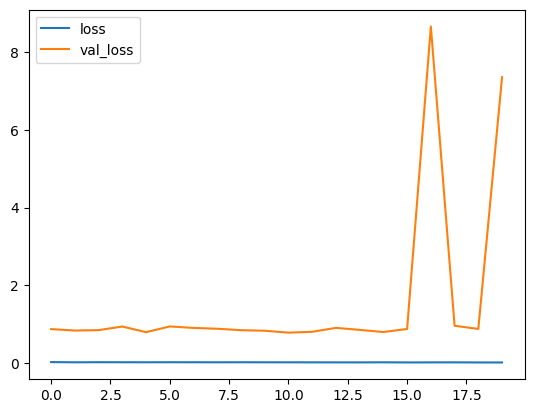

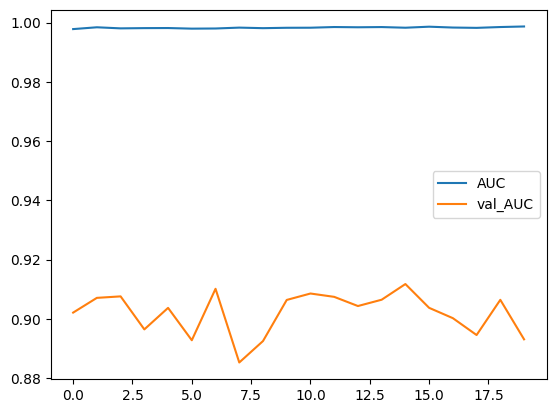

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Model Test (EPOCH 20, BATCH 64)  Accuracy:  0.8659375


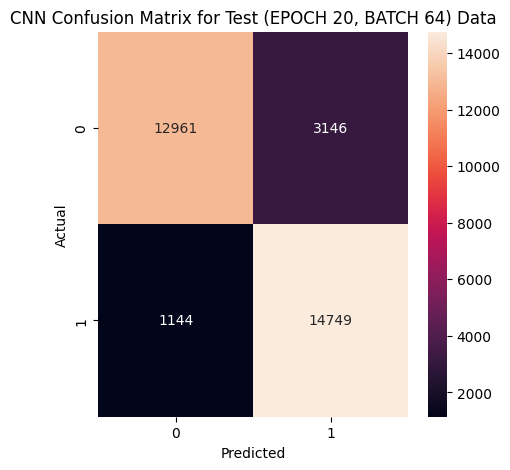

In [20]:
#################
# New Model with increased  batch size (BATCH_SIZE = 64 EPOCHS = 20)
##################

EPOCHS = 20
BATCH_SIZE = 64


cnn_model = model.fit(X_train, y_train, 
                        validation_data = (X_test, y_test), 
                        batch_size = BATCH_SIZE,
                        epochs=EPOCHS, 
                        callbacks=[reduce_lr]) 

#plot loss vs epoch and auc vs epoch

history_8 = pd.DataFrame(cnn_model.history)
history_8.loc[:,['loss','val_loss']].plot()
history_8.loc[:,['AUC','val_AUC']].plot()
plt.show()

#determine accuracy
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_test, axis=1)

acc = accuracy_score(y_val, y_pred)
acc_list_64.append(acc)



print("Model Test (EPOCH 20, BATCH 64)  Accuracy: ", acc)


#plot confusion matrix
conf_mat = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(5,5))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))

plt.title("CNN Confusion Matrix for Test (EPOCH 20, BATCH 64) Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


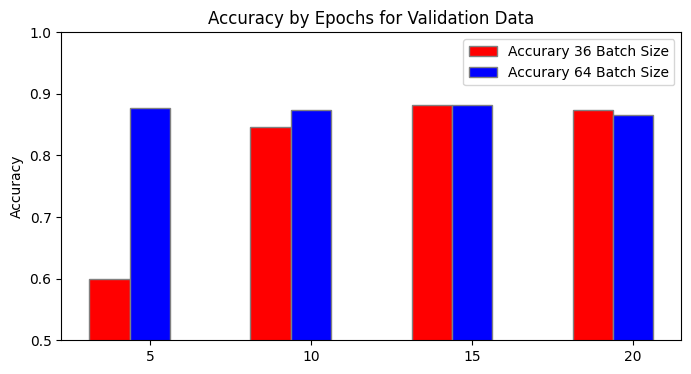

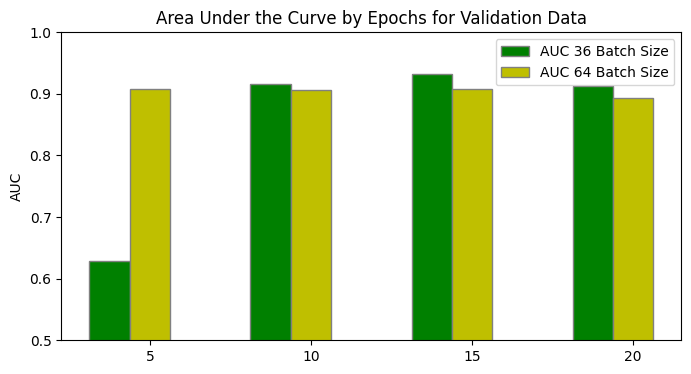

In [101]:

#############################
# Create Bar Chart for AUC and accurary Comparison
#############################

epoch = ["5","10","15","20"]

# Create Bar Chart for MSE
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(8, 4)) 

# Set position of bar on X axis 
br1 = np.arange(len(acc_list_36)) 
br2 = [x + barWidth for x in br1] 

# Make the plot
plt.bar(br1, acc_list_36, color ='r', width = barWidth, 
        edgecolor ='grey', label ='Accurary 36 Batch Size') 
plt.bar(br2, acc_list_64, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Accurary 64 Batch Size') 

# Adding Labels 
plt.ylabel('Accuracy') 
plt.xticks([r + barWidth for r in range(len(acc_list_36))],epoch)
plt.title("Accuracy by Epochs for Validation Data")
ax = plt.gca()
ax.set_ylim([0.5, 1])
plt.legend()
plt.show() 

auc_val_36 = [history_1.iloc[-1]['val_AUC'], history_2.iloc[-1]['val_AUC'],history_3.iloc[-1]['val_AUC'],history_4.iloc[-1]['val_AUC']]
auc_train_36 = [history_1.iloc[-1]['AUC'], history_2.iloc[-1]['AUC'],history_3.iloc[-1]['AUC'],history_4.iloc[-1]['AUC']]

auc_val_64 = [history_5.iloc[-1]['val_AUC'], history_6.iloc[-1]['val_AUC'],history_7.iloc[-1]['val_AUC'],history_8.iloc[-1]['val_AUC']]
auc_train_64 = [history_5.iloc[-1]['AUC'], history_6.iloc[-1]['AUC'],history_7.iloc[-1]['AUC'],history_8.iloc[-1]['AUC']]

fig = plt.subplots(figsize =(8, 4)) 

# Make the plot
plt.bar(br1, auc_val_36, color ='g', width = barWidth, 
        edgecolor ='grey', label ='AUC 36 Batch Size') 
plt.bar(br2, auc_val_64, color ='y', width = barWidth, 
        edgecolor ='grey', label ='AUC 64 Batch Size') 

# Adding Labels 
plt.ylabel('AUC') 
plt.xticks([r + barWidth for r in range(len(acc_list_36))],epoch)
plt.title("Area Under the Curve by Epochs for Validation Data")
ax = plt.gca()
ax.set_ylim([0.5, 1])
plt.legend()
plt.show() 

In [98]:
print("")
print("Accuracy by Epoch per Batch Size on Validation Data")
print(tabulate([['Batch Size - 36',acc_list_36[0],acc_list_36[1],acc_list_36[2],acc_list_36[3]], ['Batch Size - 64',acc_list_64[0],acc_list_64[1],acc_list_64[2],acc_list_64[3]]], headers=['Epoch','5','10','15','20'], tablefmt="fancy_grid"))

print("")
print("AUC by Epoch per Batch Size on Validation Data")
print(tabulate([['Batch Size - 36',auc_val_36[0],auc_val_36[1],auc_val_36[2],auc_val_36[3]], ['Batch Size - 64',auc_val_64[0],auc_val_64[1],auc_val_64[2],auc_val_64[3]]], headers=['Epoch','5','10','15','20'], tablefmt="fancy_grid"))
print("")
print("AUC by Epoch per Batch Size on Training Data")
print(tabulate([['Batch Size - 36',auc_train_36[0],auc_train_36[1],auc_train_36[2],auc_train_36[3]], ['Batch Size - 64',auc_train_64[0],auc_train_64[1],auc_train_64[2],auc_train_64[3]]], headers=['Epoch','5','10','15','20'], tablefmt="fancy_grid"))



Accuracy by Epoch per Batch Size on Validation Data
╒═════════════════╤══════════╤══════════╤══════════╤══════════╕
│ Epoch           │        5 │       10 │       15 │       20 │
╞═════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Batch Size - 36 │ 0.599875 │ 0.846125 │ 0.881844 │ 0.87325  │
├─────────────────┼──────────┼──────────┼──────────┼──────────┤
│ Batch Size - 64 │ 0.877687 │ 0.87325  │ 0.88225  │ 0.865938 │
╘═════════════════╧══════════╧══════════╧══════════╧══════════╛

AUC by Epoch per Batch Size on Validation Data
╒═════════════════╤══════════╤══════════╤══════════╤══════════╕
│ Epoch           │        5 │       10 │       15 │       20 │
╞═════════════════╪══════════╪══════════╪══════════╪══════════╡
│ Batch Size - 36 │ 0.627992 │ 0.915362 │ 0.933056 │ 0.913478 │
├─────────────────┼──────────┼──────────┼──────────┼──────────┤
│ Batch Size - 64 │ 0.907847 │ 0.905488 │ 0.907685 │ 0.893097 │
╘═════════════════╧══════════╧══════════╧══════════╧══════════╛

AU

The table and charts above summarize the eight different model's performance in accuracy and AUC scores. An interesting observation I noticed in looking at the confusion matrices is that at lower epochs numbers the models tend to have more false negatives. Higher epochs levels led to more accurate models and when misclassification did occur it is more often false positve. 

The models do very well on the training data with accuracy and AUC increasing as epoch numbers increase. However, with an increase in epoch numbers, the validation performance gets lower. This suggest there may be some overfitting at the higher epoch numbers. 

### Conclusion

This has been a great project to apply my knowledge of convolutional neural networks in a meaningful application. The main takeway is that using a higher epochs number gives better preformance. Increasing batch size at lower epoch numbers also helps improve performance, but has less of an affect at a higher number of epochs. The best model was a batch size with 36 samples and 15 epochs and gave an AUC score around 0.93 and an accuracy value of 0.88. More trials could be done with higher epochs to increase these numbers. Also making adjustments to the learning rate could also be investigated in future improvements to the project.   

### Test CNN Model on Kaggle Competition Data 



Now I use the competition test data to predict labels and create file to submit to the Kaggle competition. My best public score was 0.8339.

In [22]:
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

test_x = []
test_images = glob(f'{test_path}/*.tif')

 

for image in test_images:
    img = cv2.imread(image)     
    test_x.append(img)
    
test_x = np.array(test_x)    

print("Test Data Length: ",len(test_x))

Test Data Length:  57458


In [23]:
y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis=1)

test_ids = np.array([f.split(".")[0] for f in test_images])
test_ids =  np.array([os.path.basename(f) for f in test_ids])   

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [24]:
sub = pd.DataFrame(
    list(zip(test_ids, y_pred)),
    columns=["id", "label"],
)
sub.to_csv("/kaggle/working/submission.csv", index=False)